In this notebook we'll apply linear regression to the problem of estimating placing. That is, we want to create an estimator to determine where the runner will place. We will start with the simplest (read, most obvious) methods, and progress to less obvious, but hopefully nearly as predictive (using less data) models.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from itertools import compress
from matplotlib import pyplot as plt
import seaborn as sns
from decimal import Decimal # Used for scientific notation
%matplotlib inline

In [2]:
df = pd.read_csv('data/2017/mens_speed.csv')

In [3]:
len(df)

10391

In [68]:
df.head()

,div_place,name,bib,age,place,gender_place,5k_split,10k_split,15k_split,20k_split,...,40k_speed,last_2k_speed,10k_avg_speed,15k_avg_speed,20k_avg_speed,25k_avg_speed,30k_avg_speed,35k_avg_speed,40k_avg_speed,final_avg_speed
0,1,EDGAR YAK DE PADUA,41626,14,472,445,22.366667,44.700000,67.033333,89.466667,...,3.209243,1.212038,3.728561,3.729488,3.725782,3.679717,3.598848,3.508772,3.468308,3.464286
1,2,DAVID ROMAN,40554,15,505,473,24.783333,47.233333,68.916667,91.416667,...,3.004808,1.808072,3.528582,3.627570,3.646308,3.643784,3.604037,3.529293,3.453933,3.447022
2,3,RONALD PINEDA,41123,13,549,509,22.833333,45.566667,68.183333,90.633333,...,3.172589,1.199454,3.657644,3.666585,3.677823,3.642191,3.569304,3.483627,3.441452,3.414387
3,4,ROBERT HAWRYLO,41574,15,646,596,25.566667,48.433333,71.500000,94.866667,...,3.207184,1.679419,3.441156,3.496503,3.513703,3.498461,3.451450,3.396739,3.371828,3.368056
4,5,BRYAN SON,40561,14,711,654,25.083333,50.083333,74.183333,97.916667,...,3.094059,2.337593,3.327787,3.370029,3.404255,3.415301,3.406381,3.371544,3.334167,3.341120


In [69]:
df.columns

Index(['div_place', 'name', 'bib', 'age', 'place', 'gender_place', '5k_split',
       '10k_split', '15k_split', '20k_split', '25k_split', '30k_split',
       '35k_split', '40k_split', 'clock_time', 'net_time', 'hometown',
       '5k_speed', '10k_speed', '15k_speed', '20k_speed', '25k_speed',
       '30k_speed', '35k_speed', '40k_speed', 'last_2k_speed', '10k_avg_speed',
       '15k_avg_speed', '20k_avg_speed', '25k_avg_speed', '30k_avg_speed',
       '35k_avg_speed', '40k_avg_speed', 'final_avg_speed'],
      dtype='object')

We'll start by using split times. We will simply use all the splits except the clock_time, and use cross validation to get how well predictions are made, evaluated both using MSE and R^2.

In [70]:
lr = LinearRegression()

In [71]:
speed_cols = [str(D) + 'k_speed' for D in np.arange(5, 45, 5)]

In [75]:
X = df[speed_cols].as_matrix()
y = df['place'].as_matrix()

In [73]:
cv_score_MSE = cross_val_score(lr, X=X, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

cv_score_R2 = cross_val_score(lr, X=X, y=y, cv=5)
print("R^2 Cross Validation Results\nMean: {:.3}\nStd. Dev.: {:.3}".format(np.mean(cv_score_R2), \
                                                                             np.std(cv_score_R2)))

MSE Cross Validation Results
Mean: 2.64E+6
Std. Dev.: 6.56E+5

R^2 Cross Validation Results
Mean: 0.902
Std. Dev.: 0.0206


Let's use one last baseline, namely 5k_split. So we'll only look at where people are at the 5k mark.

In [74]:
X_5k = df['5k_split'].as_matrix()
X_5k = X_5k.reshape((len(X_5k), 1))

cv_score_MSE = cross_val_score(lr, X=X_5k, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

cv_score_R2 = cross_val_score(lr, X=X_5k, y=y, cv=5)
print("R^2 Cross Validation Results\nMean: {:.3}\nStd. Dev.: {:.3}".format(np.mean(cv_score_R2), \
                                                                             np.std(cv_score_R2)))

MSE Cross Validation Results
Mean: 1.01E+7
Std. Dev.: 7.96E+5

R^2 Cross Validation Results
Mean: 0.621
Std. Dev.: 0.0423


Not surprisingly, this drastically reduces the accuracy. In particular, the MSE nearly quadruples. However, it is silly to supply our model with speeds at all of the splits, as this is simply too much information. Thus we'll use this 5k prediction as a baseline. If we could produce a model that gives similar (or better!) results, *without* needing to know their speed, that would be great.

Next let's so how simply using L2 speed variance holds up.

In [75]:
lr = LinearRegression()

In [76]:
L2_vals = df['5k_split']*0 # Quickly create a series filled with zeros of the correct length

for col in speed_cols:
    L2_vals += np.square(df[col] - df['final_avg_speed'])
    
df['L2_speed_diff'] = L2_vals

In [77]:
X_L2 = df['L2_speed_diff'].as_matrix()
X_L2 = X_L2.reshape((len(X_L2), 1))

cv_score_MSE = cross_val_score(lr, X=X_L2, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

cv_score_R2 = cross_val_score(lr, X=X_L2, y=y, cv=5)
print("R^2 Cross Validation Results\nMean: {:.3}\nStd. Dev.: {:.3}".format(np.mean(cv_score_R2), \
                                                                             np.std(cv_score_R2)))

MSE Cross Validation Results
Mean: 2.85E+7
Std. Dev.: 3.92E+6

R^2 Cross Validation Results
Mean: -0.0649
Std. Dev.: 0.0637


Once again, the MSE increased by nearly a factor of 3 over the 5k_split prediction. Also, the R^2 value is nearly useless. This can also be seen by graphing a scatter plot with L2_speed_diff and place. However, we know that, on average, L2_speed_diff is actually a decent indicator of the top finishers when averaged, as seen below:

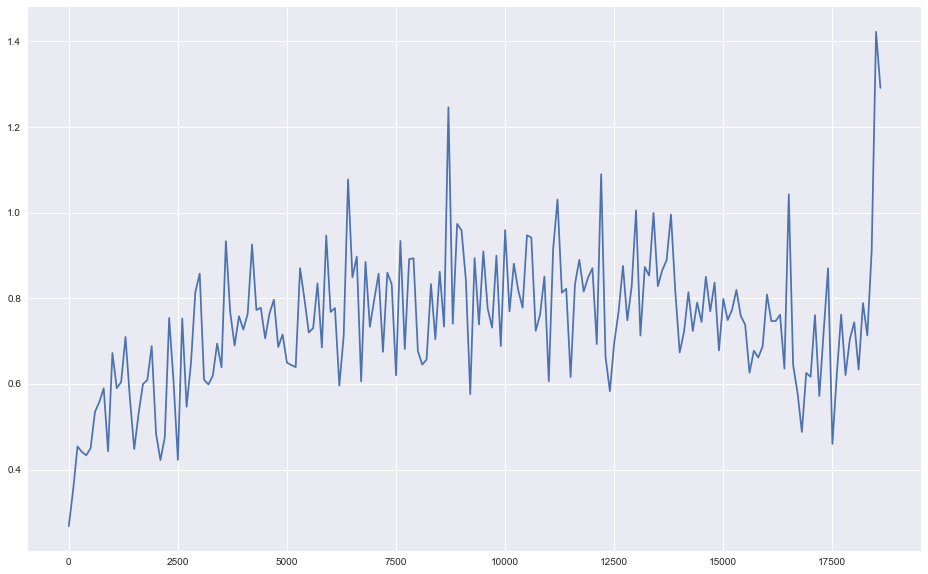

In [78]:
def L2_speed_every_N(N=100):
    return np.arange(1, 20000, N), [df[df['place'].between(n, n+N)]['L2_speed_diff'].mean() \
                                    for n in np.arange(1, 20000, N)]

fig = plt.figure(figsize=(16, 10))
x_plot, y_plot = L2_speed_every_N(100)

plt.plot(x_plot, y_plot)

In fact, we can do much better. If we normalize the L2 measure by their average speed, things look better. Again, the "big picture" view looks bad, but on average it's quite good.

In [79]:
L2_vals = df['5k_split']*0 # Quickly create a series filled with zeros of the correct length

for col in speed_cols:
    L2_vals += np.square((df[col] / df['final_avg_speed']) - 1)
    
df['L2_speed_diff_ratio'] = L2_vals

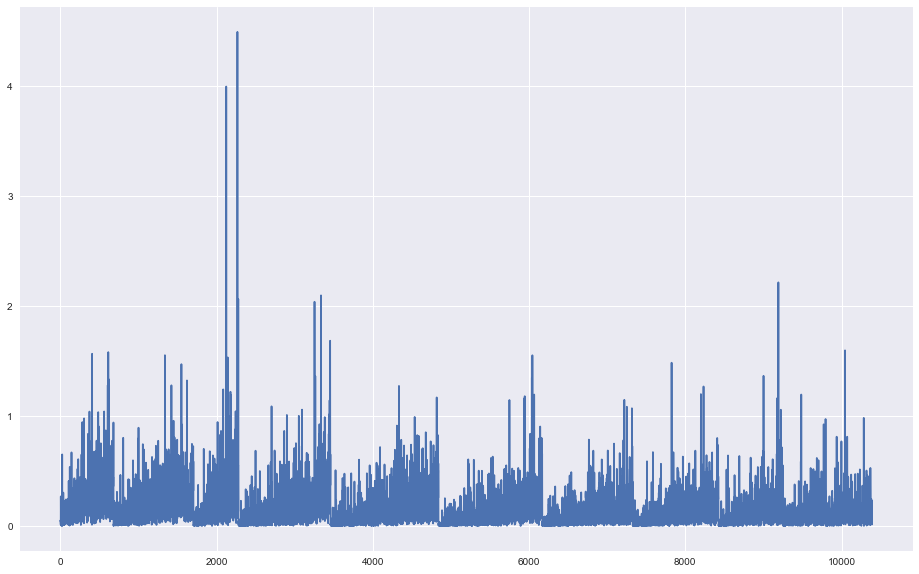

In [80]:
fig = plt.figure(figsize=(16, 10))
plt.plot(df['L2_speed_diff_ratio'])

In [16]:
def L2_speed_ratio_every_N(N=100):
    return np.arange(1, 20000, N), [df[df['place'].between(n, n+N)]['L2_speed_diff_ratio'].mean() \
                                    for n in np.arange(1, 20000, N)]

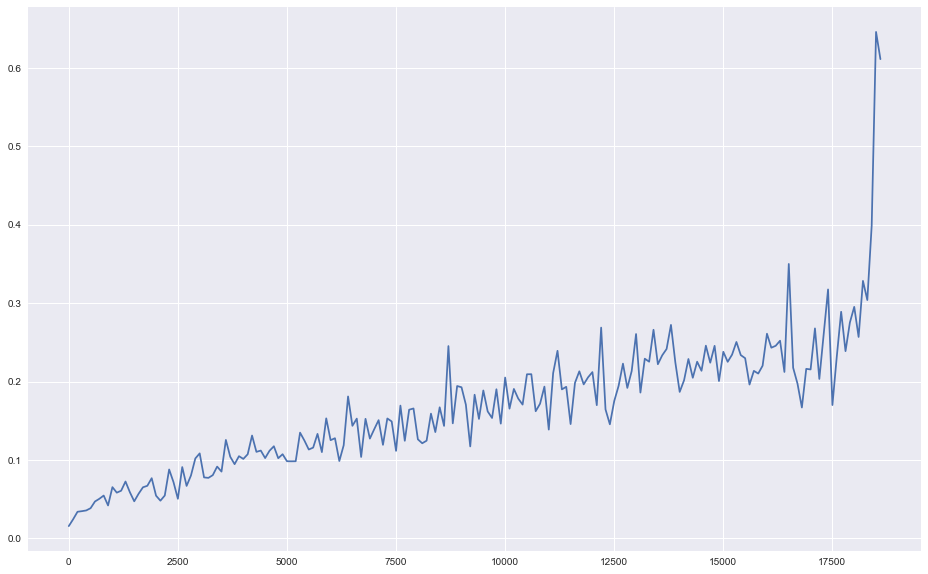

In [17]:
fig = plt.figure(figsize=(16, 10))
x_plot, y_plot = L2_speed_ratio_every_N(100)

plt.plot(x_plot, y_plot)

Again we look at the CV scores. It's not fantastic predictor, but it's something.

In [18]:
X_L2_ratio = df['L2_speed_diff_ratio'].as_matrix()
X_L2_ratio = X_L2_ratio.reshape((len(X_L2_ratio), 1)) # 1-dimensional numpy arrays need to be reshaped when given as X

cv_score_MSE = cross_val_score(lr, X=X_L2_ratio, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

cv_score_R2 = cross_val_score(lr, X=X_L2_ratio, y=y, cv=5)
print("R^2 Cross Validation Results\nMean: {:.3}\nStd. Dev.: {:.3}".format(np.mean(cv_score_R2), \
                                                                             np.std(cv_score_R2)))

MSE Cross Validation Results
Mean: 2.47E+7
Std. Dev.: 4.45E+6

R^2 Cross Validation Results
Mean: 0.0808
Std. Dev.: 0.0958


This gives an improvement in mean MSE, but also an increase in the standard deviation of MSE. Also, the R^2 becomes positive, as we would expect from it. However, the std. dev. of the R^2 also increases.

Next, let's compare 5k split vs 40k split. My guess is that this difference will correlate to how strong a runner they are, since stronger runs can maintain, or even improve their pace as the race continues, whereas weaker runners will tire. We'll compare the results using both the raw difference, and the difference as a percentage of their average speed.

In [19]:
X_5k_minus_40k = df['5k_speed'] - df['40k_speed']
X_5k_minus_40k = X_5k_minus_40k.as_matrix()
X_5k_minus_40k = X_5k_minus_40k.reshape((len(X_5k_minus_40k), 1))

cv_score_MSE = cross_val_score(lr, X=X_5k_minus_40k, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

cv_score_R2 = cross_val_score(lr, X=X_5k_minus_40k, y=y, cv=5)
print("R^2 Cross Validation Results\nMean: {:.3}\nStd. Dev.: {:.3}".format(np.mean(cv_score_R2), \
                                                                             np.std(cv_score_R2)))

MSE Cross Validation Results
Mean: 2.74E+7
Std. Dev.: 4.10E+6

R^2 Cross Validation Results
Mean: -0.0208
Std. Dev.: 0.0749


In [20]:
X_5k_minus_40k_ratio = (df['5k_speed'] - df['40k_speed'])/df['final_avg_speed']
X_5k_minus_40k_ratio = X_5k_minus_40k_ratio.as_matrix()
X_5k_minus_40k_ratio = X_5k_minus_40k_ratio.reshape((len(X_5k_minus_40k), 1))

cv_score_MSE = cross_val_score(lr, X=X_5k_minus_40k_ratio, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

cv_score_R2 = cross_val_score(lr, X=X_5k_minus_40k_ratio, y=y, cv=5)
print("R^2 Cross Validation Results\nMean: {:.3}\nStd. Dev.: {:.3}".format(np.mean(cv_score_R2), \
                                                                             np.std(cv_score_R2)))

MSE Cross Validation Results
Mean: 2.26E+7
Std. Dev.: 3.98E+6

R^2 Cross Validation Results
Mean: 0.159
Std. Dev.: 0.0895


Once again, expressing things as percentages of final speed seems to be good.

One last feature we can consider before combining them is how fast they run in the 30k to 35k split. This is chosen because in the marathon this was slightly uphill. Thus you would expect weaker runs to really struggle here, especially since it's so late in the race. We'll include this simply as a ratio of the average speed.

In [21]:
X_30k_minus_35k_ratio = (df['35k_speed'] - df['30k_speed']) / df['final_avg_speed']
X_30k_minus_35k_ratio = X_30k_minus_35k_ratio.as_matrix()
X_30k_minus_35k_ratio = X_30k_minus_35k_ratio.reshape((len(X_5k_minus_40k), 1))

cv_score_MSE = cross_val_score(lr, X=X_30k_minus_35k_ratio, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

cv_score_R2 = cross_val_score(lr, X=X_30k_minus_35k_ratio, y=y, cv=5)
print("R^2 Cross Validation Results\nMean: {:.3}\nStd. Dev.: {:.3}".format(np.mean(cv_score_R2), \
                                                                             np.std(cv_score_R2)))

MSE Cross Validation Results
Mean: 2.85E+7
Std. Dev.: 3.43E+6

R^2 Cross Validation Results
Mean: -0.0668
Std. Dev.: 0.0498


Now, let's combine all of these engineered features and use them together.

In [22]:
X_combined = np.concatenate((X_L2_ratio, X_5k_minus_40k_ratio, X_30k_minus_35k_ratio), axis=1)

cv_score_MSE = cross_val_score(lr, X=X_combined, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

cv_score_R2 = cross_val_score(lr, X=X_combined, y=y, cv=5)
print("R^2 Cross Validation Results\nMean: {:.3}\nStd. Dev.: {:.3}".format(np.mean(cv_score_R2), \
                                                                             np.std(cv_score_R2)))

MSE Cross Validation Results
Mean: 2.16E+7
Std. Dev.: 3.69E+6

R^2 Cross Validation Results
Mean: 0.195
Std. Dev.: 0.0804


While this is not fantastic, it still is the best MSE I've achieved. It's roughly a factor of 2 worse than simply using the 5k split alone.

Next, let's try plugging this into a decision tree regressor, along with the age.

In [23]:
from sklearn.tree import DecisionTreeRegressor

In [24]:
X_age = df['age'].as_matrix().reshape((len(df['age']), 1))
X_combined_age = np.concatenate((X_combined, X_age), axis=1)

reg = DecisionTreeRegressor()

cv_score_MSE = cross_val_score(reg, X=X_combined_age, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

MSE Cross Validation Results
Mean: 5.03E+7
Std. Dev.: 1.45E+7



Let's do it again, but with a grid search with CV to determine the best hyperparameters for the tree.

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
param_grid = [
    {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [100, 150, 200, 250, 300, 350, 400, 450, 500]}
]

reg = GridSearchCV(reg, cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')

reg.fit(X_combined_age, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'min_samples_split': [2, 3, 4, 5], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [100, 150, 200, 250, 300, 350, 400, 450, 500]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [27]:
print("Best parameters set found on development set:")
print()
print(reg.best_params_)

Best parameters set found on development set:

{'min_samples_split': 2, 'max_depth': 4, 'min_samples_leaf': 300}


In [28]:
max_depth, min_samples_leaf, min_samples_split = \
        reg.best_params_['max_depth'], reg.best_params_['min_samples_leaf'], reg.best_params_['min_samples_split']

In [29]:
reg = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)

cv_score_MSE = cross_val_score(reg, X=X_combined_age, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

MSE Cross Validation Results
Mean: 2.01E+7
Std. Dev.: 3.81E+6



So this gives a slight improvement over the linear model, and we are now just barely below the cusp of being a factor of two above the 5k_split MSE. Improvement! Let's try this all again, but using hte random forest regressor.

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
reg = RandomForestRegressor()

param_grid = [
    {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [100, 150, 200, 250, 300, 350, 400, 450, 500]}
]

reg = GridSearchCV(reg, cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')

reg.fit(X_combined_age, y)

print("Best parameters set found on development set:")
print()
print(reg.best_params_)
print()

max_depth, min_samples_leaf, min_samples_split = \
        reg.best_params_['max_depth'], reg.best_params_['min_samples_leaf'], \
        reg.best_params_['min_samples_split']

reg = RandomForestRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, \
                            min_samples_split=min_samples_split)
        
cv_score_MSE = cross_val_score(reg, X=X_combined_age, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

Best parameters set found on development set:

{'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 150}

MSE Cross Validation Results
Mean: 2.00E+7
Std. Dev.: 3.68E+6



So again, this gives a (very slight) improvement. It seems clear though that if we want to reduce the MSE by a factor of two, new features need to be engineered.

Let's try throwing the kitchen sink at the Random Forest. Namely, we'll include the speed variation between each of the 5k recordings (so 0 to 5k 5k to 10k, etc.) and just see how it does.

In [81]:
df['5k_to_10k_L2_ratio'] = np.square( (df['10k_speed'] - df['5k_speed']) / df['final_avg_speed'] )
df['10k_to_15k_L2_ratio'] = np.square( (df['15k_speed'] - df['10k_speed']) / df['final_avg_speed'] )
df['15k_to_20k_L2_ratio'] = np.square( (df['20k_speed'] - df['15k_speed']) / df['final_avg_speed'] )
df['20k_to_25k_L2_ratio'] = np.square( (df['25k_speed'] - df['20k_speed']) / df['final_avg_speed'] )
df['25k_to_30k_L2_ratio'] = np.square( (df['30k_speed'] - df['25k_speed']) / df['final_avg_speed'] )
df['30k_to_35k_L2_ratio'] = np.square( (df['35k_speed'] - df['30k_speed']) / df['final_avg_speed'] )
df['35k_to_40k_L2_ratio'] = np.square( (df['40k_speed'] - df['35k_speed']) / df['final_avg_speed'] )

In [33]:
X_kitchen_sink = df[['5k_to_10k_L2_ratio', '10k_to_15k_L2_ratio', '15k_to_20k_L2_ratio', \
                    '20k_to_25k_L2_ratio', '25k_to_30k_L2_ratio', '30k_to_35k_L2_ratio', '35k_to_40k_L2_ratio', \
                    'L2_speed_diff_ratio']].as_matrix()

In [34]:
reg = RandomForestRegressor()

param_grid = [
    {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [100, 150, 200, 250, 300, 350, 400, 450, 500]}
]

reg = GridSearchCV(reg, cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')

reg.fit(X_kitchen_sink, y)

print("Best parameters set found on development set:")
print()
print(reg.best_params_)
print()

max_depth, min_samples_leaf, min_samples_split = \
        reg.best_params_['max_depth'], reg.best_params_['min_samples_leaf'], \
        reg.best_params_['min_samples_split']

reg = RandomForestRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, \
                            min_samples_split=min_samples_split)
        
cv_score_MSE = cross_val_score(reg, X=X_kitchen_sink, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

Best parameters set found on development set:

{'min_samples_split': 3, 'max_depth': 8, 'min_samples_leaf': 100}

MSE Cross Validation Results
Mean: 1.52E+7
Std. Dev.: 3.44E+6



That's quite an improvement! We're now only at 50% worse than simply using 5k split. Let's next try a gradient boosted regressor just to see how it turns out.

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = [
    {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [100, 150, 200, 250, 300, 350, 400, 450, 500]}
]

GBreg = GradientBoostingRegressor()

GBreg = GridSearchCV(GBreg, cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')

GBreg.fit(X_kitchen_sink, y)

print("Best parameters set found on development set:")
print()
print(GBreg.best_params_)
print()

max_depth, min_samples_leaf, min_samples_split = \
        GBreg.best_params_['max_depth'], GBreg.best_params_['min_samples_leaf'], \
        GBreg.best_params_['min_samples_split']

reg = RandomForestRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, \
                            min_samples_split=min_samples_split)
        
cv_score_MSE = cross_val_score(GBreg, X=X_kitchen_sink, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

max_depth, min_samples_leaf, min_samples_split = \
        GBreg.best_params_['max_depth'], GBreg.best_params_['min_samples_leaf'], \
        GBreg.best_params_['min_samples_split']

reg = RandomForestRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, \
                            min_samples_split=min_samples_split)
        
cv_score_MSE = cross_val_score(GBreg, X=X_kitchen_sink, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

So it looks like switching to gradient boosting gives a slight improvement over a straight-forward random forest. However, the run time is also much, much longer. Thus it should only be used when I'm right at/over the threshold I'm aiming over.

Let's try some more feature engineering to try and close this gap. We'll count the number of splits which are above and below their 5k speed. The idea being that slower runners should have essentially all splits slower than 5k, but elite runners might be better at holding that pace.

In [38]:
split_comp_to_5k = df['5k_speed'] * 0
for col in speed_cols:
    split_comp_to_5k += sum(df[col] - df['5k_speed'])
    
X_split_comp_to_5k = split_comp_to_5k.as_matrix().reshape((10391,1))

In [39]:
X_kitchen_sink_2 = np.concatenate((X_kitchen_sink, X_split_comp_to_5k), axis=1)

In [40]:
reg = RandomForestRegressor(max_depth=10, min_samples_leaf=100, \
                            min_samples_split=4)
        
cv_score_MSE = cross_val_score(reg, X=X_kitchen_sink_2, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

MSE Cross Validation Results
Mean: 1.52E+7
Std. Dev.: 3.37E+6



No improvement, so we'll ditch that feature.

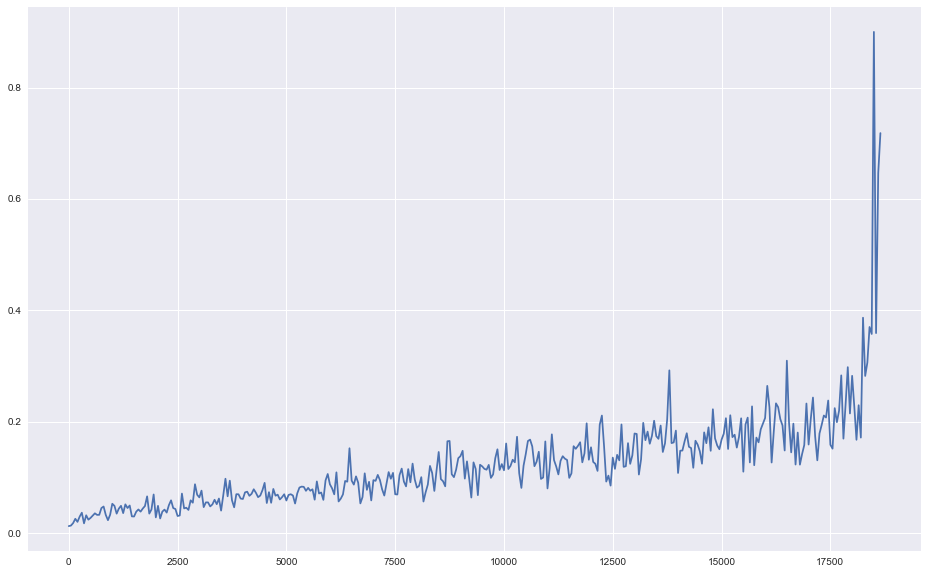

In [41]:
def L2_speed_ratio_every_N(N=100):
    vals = [np.square((df[df['place'].between(n, n+N)]['40k_speed'] - df[df['place'].between(n, n+N)]['5k_speed'])/df['final_avg_speed']).mean() \
             for n in np.arange(1, 20000, N)]
    return np.arange(1, 20000, N), vals

fig = plt.figure(figsize=(16, 10))
x_plot, y_plot = L2_speed_ratio_every_N(50)

plt.plot(x_plot, y_plot)

In [82]:
df['5k_to_10k_diff_ratio'] = (df['10k_speed'] - df['5k_speed']) / np.square(df['final_avg_speed'])
df['10k_to_15k_diff_ratio'] = (df['15k_speed'] - df['10k_speed']) / np.square(df['final_avg_speed'] )
df['15k_to_20k_diff_ratio'] = (df['20k_speed'] - df['15k_speed']) / np.square(df['final_avg_speed'] )
df['20k_to_25k_diff_ratio'] = (df['25k_speed'] - df['20k_speed']) / np.square(df['final_avg_speed'])
df['25k_to_30k_diff_ratio'] = (df['30k_speed'] - df['25k_speed']) / np.square(df['final_avg_speed'] )
df['30k_to_35k_diff_ratio'] = (df['35k_speed'] - df['30k_speed']) / np.square(df['final_avg_speed'] )
df['35k_to_40k_diff_ratio'] = (df['40k_speed'] - df['35k_speed']) / np.square(df['final_avg_speed'] )

Let's also try adding in the 40k to 5k difference ratio

In [83]:
df['5k_to_40k_diff_ratio'] = (df['40k_speed'] - df['5k_speed']) / np.square(df['final_avg_speed'] )

In [43]:
X_kitchen_sink2 = df[['5k_to_10k_diff_ratio', '10k_to_15k_diff_ratio', '15k_to_20k_diff_ratio', \
                    '20k_to_25k_diff_ratio', '25k_to_30k_diff_ratio', '30k_to_35k_diff_ratio', '35k_to_40k_diff_ratio', \
                    'L2_speed_diff_ratio']].as_matrix()

In [44]:
reg = RandomForestRegressor()

param_grid = [
    {'max_depth': [10, 11, 12, 13, 14, 15],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [25, 50, 75, 100, 150, 200, 250, 300]}
]

reg = GridSearchCV(reg, cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')

reg.fit(X_kitchen_sink2, y)

print("Best parameters set found on development set:")
print()
print(reg.best_params_)
print()

max_depth, min_samples_leaf, min_samples_split = \
        reg.best_params_['max_depth'], reg.best_params_['min_samples_leaf'], \
        reg.best_params_['min_samples_split']

reg = RandomForestRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, \
                            min_samples_split=min_samples_split)
        
cv_score_MSE = cross_val_score(reg, X=X_kitchen_sink2, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

Best parameters set found on development set:

{'min_samples_split': 5, 'max_depth': 14, 'min_samples_leaf': 25}

MSE Cross Validation Results
Mean: 8.74E+6
Std. Dev.: 2.10E+6



Feature ranking:
1. feature 0 (0.488561)
2. feature 2 (0.203490)
3. feature 3 (0.131538)
4. feature 1 (0.091434)
5. feature 4 (0.032678)
6. feature 7 (0.026066)
7. feature 5 (0.016389)
8. feature 6 (0.009844)


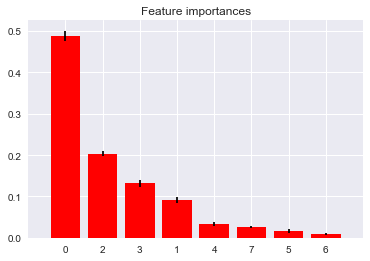

In [45]:
reg.fit(X_kitchen_sink2, y)
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_kitchen_sink2.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_kitchen_sink2.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_kitchen_sink2.shape[1]), indices)
plt.xlim([-1, X_kitchen_sink2.shape[1]])
plt.show()

from sklearn import tree
import graphviz

feature_names = ['5k_to_10k_diff_ratio', '10k_to_15k_diff_ratio', '15k_to_20k_diff_ratio', \
                    '20k_to_25k_diff_ratio', '25k_to_30k_diff_ratio', '30k_to_35k_diff_ratio', '35k_to_40k_diff_ratio', \
                    'L2_speed_diff_ratio']

dot_data = tree.export_graphviz(reg, out_file=None, 
                         feature_names=feature_names,   
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data) 
graph

Now that we have beaten our benchmark on the development side, let's do a real test and see! We'll use the 2016 mens results for a comparison, compute the "benchmark" for that (linear model based on 5k_split), and regress placing using the random forest regressor with the parameters given by the grid search from the 2017 data. Fingers crossed!

In [4]:
df2016 = pd.read_csv('data/2016/mens_speed.csv')

In [5]:
len(df2016)

10371

In [47]:
lr = LinearRegression()

In [48]:
X_5k = df2016['5k_split'].as_matrix()
X_5k = X_5k.reshape((len(X_5k), 1))
y2016 = df2016['place'].as_matrix()

cv_score_MSE = cross_val_score(lr, X=X_5k, y=y2016, scoring='neg_mean_squared_error', cv=5)
print("2016 MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

cv_score_R2 = cross_val_score(lr, X=X_5k, y=y2016, cv=5)
print("2016 R^2 Cross Validation Results\nMean: {:.3}\nStd. Dev.: {:.3}".format(np.mean(cv_score_R2), \
                                                                             np.std(cv_score_R2)))

2016 MSE Cross Validation Results
Mean: 1.13E+7
Std. Dev.: 2.05E+6

2016 R^2 Cross Validation Results
Mean: 0.648
Std. Dev.: 0.0751


In [49]:
df2016['5k_to_10k_diff_ratio'] = (df2016['10k_speed'] - df2016['5k_speed']) / np.square(df2016['final_avg_speed'])
df2016['10k_to_15k_diff_ratio'] = (df2016['15k_speed'] - df2016['10k_speed']) / np.square(df2016['final_avg_speed'] )
df2016['15k_to_20k_diff_ratio'] = (df2016['20k_speed'] - df2016['15k_speed']) / np.square(df2016['final_avg_speed'] )
df2016['20k_to_25k_diff_ratio'] = (df2016['25k_speed'] - df2016['20k_speed']) / np.square(df2016['final_avg_speed'])
df2016['25k_to_30k_diff_ratio'] = (df2016['30k_speed'] - df2016['25k_speed']) / np.square(df2016['final_avg_speed'] )
df2016['30k_to_35k_diff_ratio'] = (df2016['35k_speed'] - df2016['30k_speed']) / np.square(df2016['final_avg_speed'] )
df2016['35k_to_40k_diff_ratio'] = (df2016['40k_speed'] - df2016['35k_speed']) / np.square(df2016['final_avg_speed'] )

In [88]:
df2016['5k_to_40k_diff_ratio'] = (df['40k_speed'] - df['5k_speed']) / np.square(df['final_avg_speed'] )

In [50]:
L2_vals = df2016['5k_split']*0 # Quickly create a series filled with zeros of the correct length

for col in speed_cols:
    L2_vals += np.square((df[col] / df2016['final_avg_speed']) - 1)
    
df2016['L2_speed_diff_ratio'] = L2_vals

In [67]:
X_2016 = df2016[['5k_to_10k_diff_ratio', '10k_to_15k_diff_ratio', '15k_to_20k_diff_ratio', \
                    '20k_to_25k_diff_ratio', '25k_to_30k_diff_ratio', '30k_to_35k_diff_ratio', '35k_to_40k_diff_ratio', \
                    'L2_speed_diff_ratio']].as_matrix()

reg = RandomForestRegressor(max_depth=14, min_samples_leaf=25, \
                            min_samples_split=50)

reg.fit(X_kitchen_sink2, y)

y_hat = reg.predict(X_2016)

In [68]:
from sklearn.metrics import mean_squared_error

print('2016 Random Forest Regressor:\nMSE: {:.2E}'.format(Decimal(mean_squared_error(y2016, y_hat))))

2016 Random Forest Regressor:
MSE: 1.24E+7


So close! Let's train the gradient boosted forest to gain a few percent improvement.

In [53]:
y = df['place'].as_matrix()

param_grid = [
    {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [100, 150, 200, 250, 300, 350, 400, 450, 500]}
]

GBreg = GradientBoostingRegressor()

GBreg = GridSearchCV(GBreg, cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')

GBreg.fit(X_kitchen_sink2, y)

print("Best parameters set found on development set:")
print()
print(GBreg.best_params_)
print()

max_depth, min_samples_leaf, min_samples_split = \
        GBreg.best_params_['max_depth'], GBreg.best_params_['min_samples_leaf'], \
        GBreg.best_params_['min_samples_split']

reg = RandomForestRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, \
                            min_samples_split=min_samples_split)
        
cv_score_MSE = cross_val_score(GBreg, X=X_kitchen_sink2, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

Best parameters set found on development set:

{'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 100}

MSE Cross Validation Results
Mean: 5.59E+6
Std. Dev.: 1.41E+6



In [60]:
GBreg_optimized = GradientBoostingRegressor(min_samples_split=20, max_depth=10, min_samples_leaf=100)
GBreg_optimized.fit(X_kitchen_sink2, y)

y_hat_2016 = GBreg_optimized.predict(X_2016)

print('2016 Random Forest Regressor:\nMSE: {:.2E}'.format(Decimal(mean_squared_error(y2016, y_hat_2016))))

2016 Random Forest Regressor:
MSE: 3.21E+7


Now we'll make two changes. First is that we include the 5k to 40k diff ratio, in the hopes of capturing how stronger runners can maintain a fast pace at the end of the race. Second, we increase the min_samples_split grid to avoid overfitting.

In [85]:
X_kitchen_sink3 = df[['5k_to_10k_diff_ratio', '10k_to_15k_diff_ratio', '15k_to_20k_diff_ratio', \
                    '20k_to_25k_diff_ratio', '25k_to_30k_diff_ratio', '30k_to_35k_diff_ratio', '35k_to_40k_diff_ratio', \
                    '5k_to_40k_diff_ratio', 'L2_speed_diff_ratio']].as_matrix()

In [86]:
reg = RandomForestRegressor()

param_grid = [
    {'max_depth': [10, 11, 12, 13, 14, 15],
    'min_samples_split': [10, 20, 30, 40, 50],
    'min_samples_leaf': [25, 50, 75, 100, 150, 200, 250, 300]}
]

reg = GridSearchCV(reg, cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')

y = df['place'].as_matrix()

reg.fit(X_kitchen_sink3, y)

print("Best parameters set found on development set:")
print()
print(reg.best_params_)
print()

max_depth, min_samples_leaf, min_samples_split = \
        reg.best_params_['max_depth'], reg.best_params_['min_samples_leaf'], \
        reg.best_params_['min_samples_split']

#reg = RandomForestRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, \
#                            min_samples_split=min_samples_split, warm_start=True)
        
cv_score_MSE = cross_val_score(reg, X=X_kitchen_sink3, y=y, scoring='neg_mean_squared_error', cv=5)
print("2017 MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

Best parameters set found on development set:

{'max_depth': 13, 'min_samples_leaf': 25, 'min_samples_split': 50}

2017 MSE Cross Validation Results
Mean: 7.76E+6
Std. Dev.: 1.84E+6



In [90]:
X_2016 = df2016[['5k_to_10k_diff_ratio', '10k_to_15k_diff_ratio', '15k_to_20k_diff_ratio', \
                    '20k_to_25k_diff_ratio', '25k_to_30k_diff_ratio', '30k_to_35k_diff_ratio', '35k_to_40k_diff_ratio', \
                    '5k_to_40k_diff_ratio', 'L2_speed_diff_ratio']].as_matrix()

y2016 = df2016['place'].as_matrix()
y_hat_2016 = reg.predict(X_2016)

print('2016 Random Forest Regressor:\nMSE: {:.2E}'.format(Decimal(mean_squared_error(y2016, y_hat_2016))))

2016 Random Forest Regressor:
MSE: 1.37E+7


Let's try again, but dropping down the min_samples_split to try and recapture some gain.

In [94]:
reg = RandomForestRegressor()

param_grid = [
    {'max_depth': [10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [25]}
]

reg = GridSearchCV(reg, cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')

y = df['place'].as_matrix()

reg.fit(X_kitchen_sink3, y)

print("Best parameters set found on development set:")
print()
print(reg.best_params_)
print()

max_depth, min_samples_leaf, min_samples_split = \
        reg.best_params_['max_depth'], reg.best_params_['min_samples_leaf'], \
        reg.best_params_['min_samples_split']

#reg = RandomForestRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, \
#                            min_samples_split=min_samples_split, warm_start=True)
        
cv_score_MSE = cross_val_score(reg, X=X_kitchen_sink3, y=y, scoring='neg_mean_squared_error', cv=5)
print("2017 MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

Best parameters set found on development set:

{'max_depth': 15, 'min_samples_leaf': 25, 'min_samples_split': 10}

2017 MSE Cross Validation Results
Mean: 7.81E+6
Std. Dev.: 1.83E+6



In [95]:
y_hat_2016 = reg.predict(X_2016)

print('2016 Random Forest Regressor:\nMSE: {:.2E}'.format(Decimal(mean_squared_error(y2016, y_hat_2016))))

2016 Random Forest Regressor:
MSE: 1.35E+7


In [106]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_kitchen_sink3)
X_kitchen_sink3 = scaler.transform(X_kitchen_sink3)
scaler.fit(X_2016)
X_2016 = scaler.transform(X_2016)

In [110]:
reg = RandomForestRegressor()

param_grid = [
    {'max_depth': [10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [25],
    'n_estimators': [100, 200]}
]

reg = GridSearchCV(reg, cv=5, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)

y = df['place'].as_matrix()

reg.fit(X_kitchen_sink3, y)

print("Best parameters set found on training set using cross-validation:")
print()
print(reg.best_params_)
print()

max_depth, min_samples_leaf, min_samples_split = \
        reg.best_params_['max_depth'], reg.best_params_['min_samples_leaf'], \
        reg.best_params_['min_samples_split']

cv_score_MSE = cross_val_score(reg, X=X_kitchen_sink3, y=y, scoring='neg_mean_squared_error', cv=5)
print("2017 MSE Cross Validation Results\nMean: {:.2E}\nStd. Dev.: {:.2E}\n".format(-Decimal(np.mean(cv_score_MSE)), \
                                                                               Decimal(np.std(cv_score_MSE))))

Best parameters set found on development set:

{'max_depth': 15, 'min_samples_leaf': 25, 'min_samples_split': 15, 'n_estimators': 100}

2017 MSE Cross Validation Results
Mean: 7.48E+6
Std. Dev.: 1.80E+6



In [111]:
y_hat_2016 = reg.predict(X_2016)

print('2016 Random Forest Regressor:\nMSE: {:.2E}'.format(Decimal(mean_squared_error(y2016, y_hat_2016))))

2016 Random Forest Regressor:
MSE: 1.11E+7


In [ ]:
df2017 = pd.read_csv('data/2017/mens_speed.csv')
df2016 = pd.read_csv('data/2016/mens_speed.csv')

In [78]:
lr = LinearRegression()

X_5k = df['5k_split'].as_matrix()
X_5k = X_5k.reshape((len(X_5k), 1))

lr.fit(X_5k, y)

X_5k_2016 = df2016['5k_split'].as_matrix().reshape((len(df2016['5k_split']), 1))

y_hat_lr_2016 = lr.predict(X_5k_2016)

print('2016 Random Forest Regressor:\nMSE: {:.2E}'.format(Decimal(mean_squared_error(y2016, y_hat_lr_2016))))

2016 Random Forest Regressor:
MSE: 1.20E+7
